In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import scipy as scipy

Create Graph

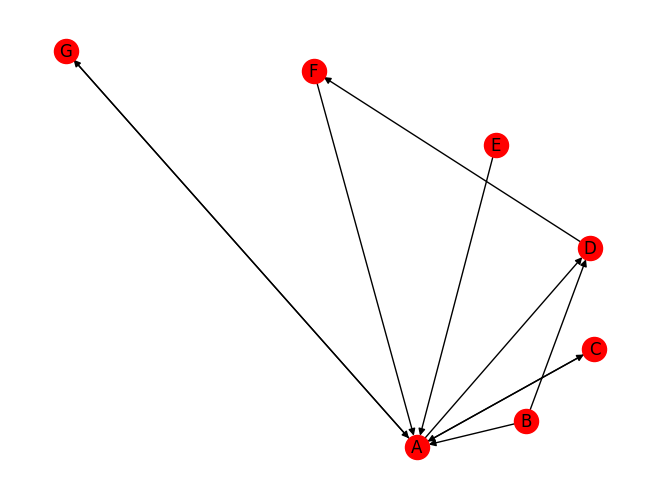

In [ ]:
G = nx.DiGraph()

[G.add_node(k) for k in ["A", "B", "C", "D", "E", "F", "G"]]
G.add_edges_from([('G','A'), ('A','G'),('B','A'),
                  ('C','A'),('A','C'),('A','D'),
                  ('E','A'),('F','A'),('B','D'),
                  ('D','F')])
pos = nx.spiral_layout(G)
nx.draw(G, pos, with_labels = True, node_color="red")

Run pagerank

{'A': 0.40001520046189115, 'B': 0.021428571428571432, 'C': 0.1347663991011727, 'D': 0.14387354195831553, 'E': 0.021428571428571432, 'F': 0.1437213165203047, 'G': 0.1347663991011727}


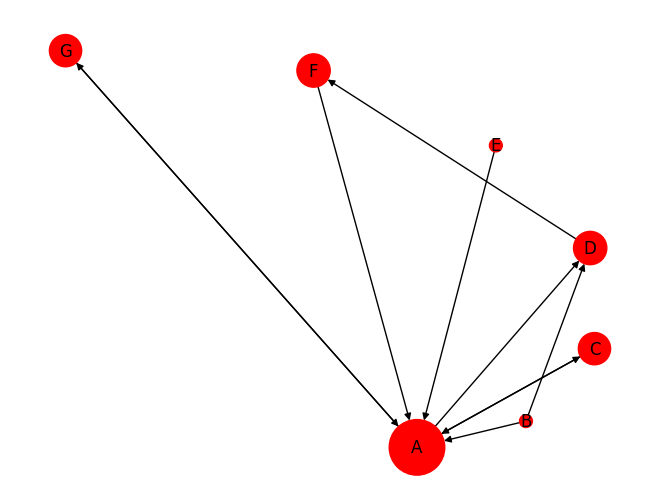

In [ ]:
pr1 = nx.pagerank(G)
print(pr1)
nx.draw(G, pos, nodelist=list(pr1.keys()), node_size=[round(v * 4000) for v in pr1.values()], 
        with_labels = True, node_color="red")   

Adjusting dampening/teleports

In [ ]:
pr_09 = nx.pagerank(G, alpha=0.9)
pr_08 = nx.pagerank(G, alpha=0.8)
res = pd.DataFrame({"alpha=0.9": pr_09, "alpha=0.8": pr_08})
res

,alpha=0.9,alpha=0.8
A,0.409777,0.389972
B,0.014286,0.028571
C,0.137218,0.132564
D,0.143647,0.143993
E,0.014286,0.028571
F,0.143568,0.143765
G,0.137218,0.132564


Personal PageRank

{'A': 0.4147475495142858, 'B': 0.0, 'C': 0.12442358835485172, 'D': 0.12442358835485172, 'E': 0.09999999999999998, 'F': 0.11198168542115904, 'G': 0.12442358835485172}


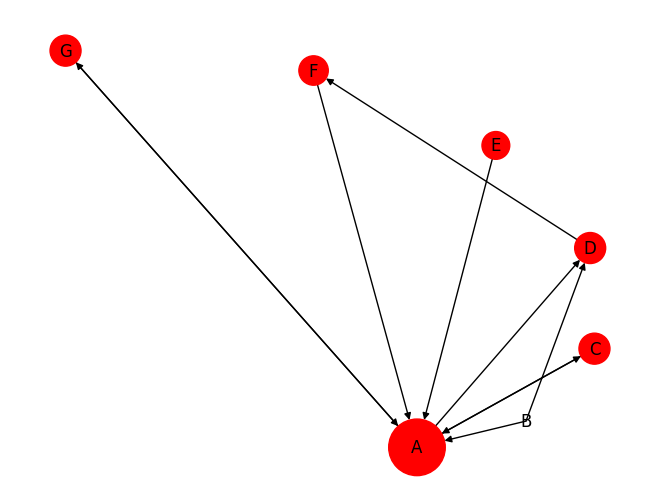

In [ ]:
pr_e = nx.pagerank(G, alpha=0.9, personalization={'E': 1})
print(pr_e)
nx.draw(G, pos, nodelist=list(pr_e.keys()), node_size=[round(v * 4000) for v in pr_e.values()], 
        with_labels = True, node_color="red")   

MovieLens Recommender

Load data

In [ ]:
import urllib.request
import shutil
import zipfile
import os
filename='ml-100k'
data_url='https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urllib.request.urlopen(data_url) as response, open('./'+filename, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
print('Download completed')
with zipfile.ZipFile('./'+filename, 'r') as zip_ref:
    zip_ref.extractall('./sample_data/')
dirs = [x[0] for x in os.walk("./sample_data")]
ml = filter(lambda dirName: dirName if ('ml' in dirName) else '', list(dirs))
dt_dir_name= list(ml)[0]
rdata = pd.read_csv(dt_dir_name +'/'+ 'u.data', delimiter='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
rdata['userId'] = 'u' + rdata['userId'].astype(str)
rdata['movieId'] = 'i' + rdata['movieId'].astype(str)

usrdata = pd.read_csv(dt_dir_name +'/'+'u.user', delimiter='|', names=['user id', 'age' ,'gender' ,'occupation' , 'zip code'])
item_data = pd.read_csv(dt_dir_name +'/'+ 'u.item', delimiter='|', encoding="ISO-8859-1", header=None)
item_data = item_data[[0,1]]
item_data.columns = ['movieId','movieTitle']
item_data['movieId'] = 'i' + item_data['movieId'].astype(str)
item_data = item_data.set_index('movieId')
rdata.head()

Download completed


,userId,movieId,rating,timestamp
0,u196,i242,3,881250949
1,u186,i302,3,891717742
2,u22,i377,1,878887116
3,u244,i51,2,880606923
4,u166,i346,1,886397596


In [ ]:
rdata = pd.merge(rdata, item_data, how='left', on='movieId')
rdata.head()

,userId,movieId,rating,timestamp,movieTitle
0,u196,i242,3,881250949,Kolya (1996)
1,u186,i302,3,891717742,L.A. Confidential (1997)
2,u22,i377,1,878887116,Heavyweights (1994)
3,u244,i51,2,880606923,Legends of the Fall (1994)
4,u166,i346,1,886397596,Jackie Brown (1997)


Create graph

In [ ]:
#Create a graph
G = nx.Graph()
#Add nodes
G.add_nodes_from(rdata.userId, bipartite=0)
G.add_nodes_from(rdata.movieId, bipartite=1)
#Add weights for edges
G.add_weighted_edges_from([(uId, mId,rating) for (uId, mId, rating)
              in rdata[['userId', 'movieId', 'rating']].to_numpy()])
print(nx.info(G))
print(nx.is_bipartite(G))

Graph with 2625 nodes and 100000 edges
True


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_53644\255363031.py:9: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Run pagerank

In [ ]:
movie_rank = nx.pagerank(G, alpha=0.85)

In [ ]:
def return_top_movies(movie_rank):
  movie_rank = dict(sorted(movie_rank.items(), key=lambda item: item[1], reverse=True))
  top_10_movies = []
  for key, value in movie_rank.items():
    if 'i' in key:
      top_10_movies.append(key)
      if len(top_10_movies) == 10:
        break
  return item_data.loc[top_10_movies]

In [ ]:
return_top_movies(movie_rank)

,movieTitle
movieId,
i50,Star Wars (1977)
i258,Contact (1997)
i100,Fargo (1996)
i181,Return of the Jedi (1983)
i286,"English Patient, The (1996)"
i288,Scream (1996)
i300,Air Force One (1997)
i127,"Godfather, The (1972)"
i1,Toy Story (1995)


In [ ]:
user_query = 'u196'
recommendation = nx.pagerank(G, alpha=0.85, personalization={user_query:1})
return_top_movies(recommendation)

,movieTitle
movieId,
i286,"English Patient, The (1996)"
i153,"Fish Called Wanda, A (1988)"
i8,Babe (1995)
i655,Stand by Me (1986)
i285,Secrets & Lies (1996)
i692,"American President, The (1995)"
i663,Being There (1979)
i67,Ace Ventura: Pet Detective (1994)
i25,"Birdcage, The (1996)"
